# Evaluation: Extrapolate the learning curve with a cutoff

In [1]:
import h5py
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
import scipy.stats as stats

warnings.filterwarnings('ignore')
import lcpfn 
from lcpfn import bar_distribution, encoders, train
from lcpfn import train as lctrain

### Load LCDB 1.1 data

In [2]:
### hyperparameter
OPENML_ID = {0: '3', 1: '6', 2: '11', 3: '12', 4: '13', 5: '14', 6: '15', 7: '16', 8: '18', 9: '21', 10: '22', 11: '23', 12: '24', 13: '26', 14: '28', 15: '29', 16: '30', 17: '31', 18: '32', 19: '36', 20: '37', 21: '38', 22: '44', 23: '46', 24: '50', 25: '54', 26: '55', 27: '57', 28: '60', 29: '61', 30: '151', 31: '179', 32: '180', 33: '181', 34: '182', 35: '184', 36: '185', 37: '188', 38: '201', 39: '273', 40: '293', 41: '299', 42: '300', 43: '307', 44: '336', 45: '346', 46: '351', 47: '354', 48: '357', 49: '380', 50: '389', 51: '390', 52: '391', 53: '392', 54: '393', 55: '395', 56: '396', 57: '398', 58: '399', 59: '401', 60: '446', 61: '458', 62: '469', 63: '554', 64: '679', 65: '715', 66: '718', 67: '720', 68: '722', 69: '723', 70: '727', 71: '728', 72: '734', 73: '735', 74: '737', 75: '740', 76: '741', 77: '743', 78: '751', 79: '752', 80: '761', 81: '772', 82: '797', 83: '799', 84: '803', 85: '806', 86: '807', 87: '813', 88: '816', 89: '819', 90: '821', 91: '822', 92: '823', 93: '833', 94: '837', 95: '843', 96: '845', 97: '846', 98: '847', 99: '849', 100: '866', 101: '871', 102: '881', 103: '897', 104: '901', 105: '903', 106: '904', 107: '910', 108: '912', 109: '913', 110: '914', 111: '917', 112: '923', 113: '930', 114: '934', 115: '953', 116: '958', 117: '959', 118: '962', 119: '966', 120: '971', 121: '976', 122: '977', 123: '978', 124: '979', 125: '980', 126: '991', 127: '993', 128: '995', 129: '1000', 130: '1002', 131: '1018', 132: '1019', 133: '1020', 134: '1021', 135: '1036', 136: '1040', 137: '1041', 138: '1042', 139: '1049', 140: '1050', 141: '1053', 142: '1056', 143: '1063', 144: '1067', 145: '1068', 146: '1069', 147: '1083', 148: '1084', 149: '1085', 150: '1086', 151: '1087', 152: '1088', 153: '1116', 154: '1119', 155: '1120', 156: '1128', 157: '1130', 158: '1134', 159: '1138', 160: '1139', 161: '1142', 162: '1146', 163: '1161', 164: '1166', 165: '1216', 166: '1233', 167: '1235', 168: '1236', 169: '1441', 170: '1448', 171: '1450', 172: '1457', 173: '1461', 174: '1462', 175: '1464', 176: '1465', 177: '1468', 178: '1475', 179: '1477', 180: '1478', 181: '1479', 182: '1480', 183: '1483', 184: '1485', 185: '1486', 186: '1487', 187: '1488', 188: '1489', 189: '1494', 190: '1497', 191: '1499', 192: '1501', 193: '1503', 194: '1509', 195: '1510', 196: '1515', 197: '1566', 198: '1567', 199: '1575', 200: '1590', 201: '1592', 202: '1597', 203: '4134', 204: '4135', 205: '4137', 206: '4534', 207: '4538', 208: '4541', 209: '6332', 210: '23381', 211: '23512', 212: '23517', 213: '40498', 214: '40499', 215: '40664', 216: '40668', 217: '40670', 218: '40672', 219: '40677', 220: '40685', 221: '40687', 222: '40701', 223: '40713', 224: '40900', 225: '40910', 226: '40923', 227: '40927', 228: '40966', 229: '40971', 230: '40975', 231: '40978', 232: '40979', 233: '40981', 234: '40982', 235: '40983', 236: '40984', 237: '40994', 238: '40996', 239: '41027', 240: '41142', 241: '41143', 242: '41144', 243: '41145', 244: '41146', 245: '41150', 246: '41156', 247: '41157', 248: '41158', 249: '41159', 250: '41161', 251: '41163', 252: '41164', 253: '41165', 254: '41166', 255: '41167', 256: '41168', 257: '41169', 258: '41228', 259: '41972', 260: '42734', 261: '42742', 262: '42769', 263: '42809', 264: '42810'}
LEARNER_ZOO = {0: 'SVC_linear', 1: 'SVC_poly', 2: 'SVC_rbf', 3: 'SVC_sigmoid', 4: 'Decision Tree', 5: 'ExtraTree', 6: 'LogisticRegression', 7: 'PassiveAggressive', 8: 'Perceptron', 9: 'RidgeClassifier', 10: 'SGDClassifier', 11: 'MLP', 12: 'LDA', 13: 'QDA', 14: 'BernoulliNB', 15: 'MultinomialNB', 16: 'ComplementNB', 17: 'GaussianNB', 18: 'KNN', 19: 'NearestCentroid', 20: 'ens.ExtraTrees', 21: 'ens.RandomForest', 22: 'ens.GradientBoosting', 23: 'DummyClassifier'}
ANCHOR_SIZE = np.ceil(16 * 2 ** ((np.arange(137)) / 8)).astype(int)

### load data: validation accuracy
lc_data = h5py.File(Path.cwd() / 'dataset/LCDB11_ACC_265_noFS_raw.hdf5', 'r')['accuracy'][...][:,:,:,:,:,1]

mean_valid_lc_nofs =np.nanmean(lc_data, axis=(2, 3))

In [3]:
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

Learner_A = 20
Learner_B = 3

train_split = 0.8
test_split = 0.5

In [150]:
# ### dataset split
# # SEED = 43
# # random.seed(SEED)
# # np.random.seed(SEED)
# # torch.cuda.manual_seed(SEED)
# # torch.manual_seed(SEED)
# 
# splitTrain = 0.9
# splitTest = 0.7
# learnerA = [4, 5, 20, 21]
# learnerB = [14, 15, 16, 17]
# 
# train_data_indices, test_data_indices = train_test_split(np.arange(len(OPENML_ID)), test_size=0.2, random_state=42)
# 
# ### learner split
# train_learner_indices = np.array([14])  
# train_learner_indices_2 = np.array([15])
# train_learner_indices_3 = np.array([16])
# train_learner_indices_4 = np.array([17])
# 
# test_learner_indices = np.array([8])    
# 
# ### UD, UL, UDUL
# # td1 = lc_data[train_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # td2 = lc_data[train_data_indices][:, train_learner_indices_2, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # td3 = lc_data[train_data_indices][:, train_learner_indices_3, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # td4 = lc_data[train_data_indices][:, train_learner_indices_4, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # 
# # # train_data = lc_data[train_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # train_data = np.concatenate((td1, td2, td3, td4), axis=0)
# # 
# # ttd1 = lc_data[test_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # ttd2 = lc_data[test_data_indices][:, train_learner_indices_2, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # ttd3 = lc_data[test_data_indices][:, train_learner_indices_3, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # ttd4 = lc_data[test_data_indices][:, train_learner_indices_4, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # test_data_UD = np.concatenate((ttd1, ttd2, ttd3, ttd4), axis=0)
# # 
# # test_data_UL = lc_data[train_data_indices][:, test_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# # test_data_UDUL = lc_data[test_data_indices][:, test_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# train_data_A = None
# 
# for learner in learnerA:
#     learner = np.array([learner])
#     td = lc_data[train_data_indices][:, learner, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
#     train_data_A = np.concatenate((train_data_A, td), axis=0) if train_data_A is not None else td
# 
# train_data_B = None
# for learner in learnerB:
#     learner = np.array([learner])
#     td = lc_data[train_data_indices][:, learner, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
#     train_data_B = np.concatenate((train_data_B, td), axis=0) if train_data_B is not None else td
# 
# size_to_sample = int(splitTrain * len(train_data_A))
# 
# sample1 = train_data_A[np.random.choice(train_data_A.shape[0], size_to_sample, replace=False), :]
# sample2 = train_data_B[np.random.choice(train_data_B.shape[0], len(train_data_A) - size_to_sample, replace=False), :]
# 
# print(sample1.shape)
# print(sample2.shape)
# 
# train_data = np.concatenate((sample1, sample2), axis=0)
# 
# print(train_data.shape)
#     # test_data_UD_A = lc_data[test_data_indices][:, train_learner_indices_A, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
#     # test_data_UD_B = lc_data[test_data_indices][:, train_learner_indices_B, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
# test_data_UD_A = None
# 
# for learner in learnerA:
#     learner = np.array([learner])
#     td = lc_data[test_data_indices][:, learner, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
#     test_data_UD_A = np.concatenate((test_data_UD_A, td), axis=0) if test_data_UD_A is not None else td
# 
# test_data_UD_B = None
# for learner in learnerB:
#     learner = np.array([learner])
#     td = lc_data[test_data_indices][:, learner, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
#     test_data_UD_B = np.concatenate((test_data_UD_B, td), axis=0) if test_data_UD_B is not None else td
# 
# size_to_sample_test = int(splitTest * len(test_data_UD_A))
# print(size_to_sample_test)
# sample1Test = test_data_UD_A[np.random.choice(test_data_UD_A.shape[0], size_to_sample_test, replace=False), :]
# sample2Test = test_data_UD_B[np.random.choice(test_data_UD_B.shape[0], len(test_data_UD_A) - size_to_sample_test, replace=False), :]
# 
# test_data_UD = np.concatenate((sample1Test, sample2Test), axis=0)
# 
# print(f"Train data shape: {train_data.shape}")  
# print(f"Test data UD shape: {test_data_UD.shape}")
# # print(f"Test data UL shape: {test_data_UL.shape}")
# # print(f"Test data UDUL shape: {test_data_UDUL.shape}")

Train data shape: (5300, 1, 137)
Test data UD shape: (2650, 1, 137)


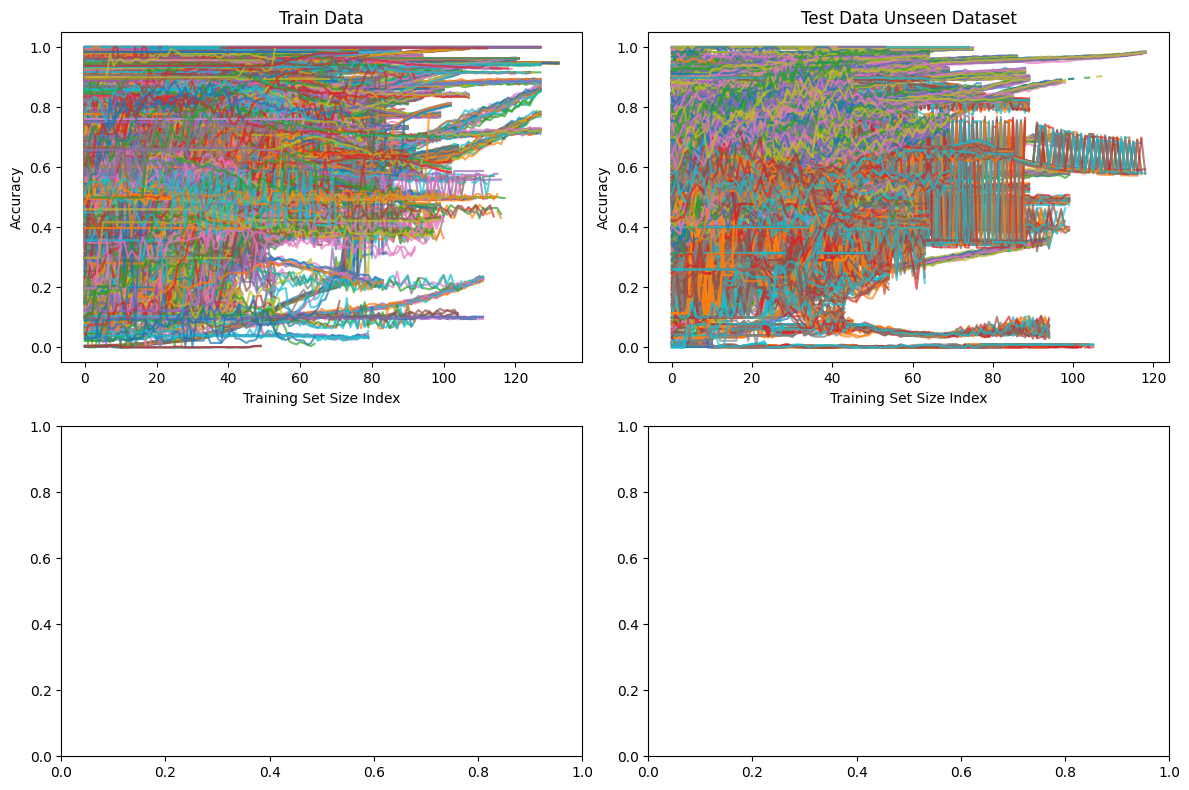

In [4]:
### dataset split
train_data_indices, test_data_indices = train_test_split(np.arange(len(OPENML_ID)), test_size=0.2, random_state=42)
### learner split
train_learner_indices_A = np.array([Learner_A])    
train_learner_indices_B = np.array([Learner_B])    

### UD, UL, UDUL
train_data_A = lc_data[train_data_indices][:, train_learner_indices_A, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
train_data_B = lc_data[train_data_indices][:, train_learner_indices_B, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)

test_data_UD_A = lc_data[test_data_indices][:, train_learner_indices_A, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UD_B = lc_data[test_data_indices][:, train_learner_indices_B, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)

size_to_sample = int(np.ceil(len(train_data_A) * train_split))
sample1 = train_data_A[np.random.choice(train_data_A.shape[0], size_to_sample, replace=False), :]
sample2 = train_data_B[np.random.choice(train_data_B.shape[0], len(train_data_A) - size_to_sample, replace=False), :]

train_data = np.concatenate((sample1, sample2), axis=0)

# size_to_sample_test = int(np.ceil(len(test_data_UD_A) * test_split))
# test_sample1 = test_data_UD_A[np.random.choice(test_data_UD_A.shape[0], size_to_sample_test, replace=False), :]
# test_sample2 = test_data_UD_B[np.random.choice(test_data_UD_B.shape[0], len(test_data_UD_A) - size_to_sample_test, replace=False), :]
# 
# test_data_UD = np.concatenate((test_sample1, test_sample2), axis=0)

tt = np.array([Learner_A, Learner_B])
test_data_UD = lc_data[test_data_indices][:, tt, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
UD_A = lc_data[test_data_indices][:, train_learner_indices_A, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
print(f"Train data shape: {train_data.shape}")  
print(f"Test data UD shape: {test_data_UD.shape}")

def plot_learning_curves(ax, data, title):
    for idx in range(len(data)):  
        ax.plot(data[idx, 0, :], linestyle='-', alpha=0.7)

    ax.set_xlabel("Training Set Size Index")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(axes[0, 0], train_data, "Train Data")
plot_learning_curves(axes[0, 1], test_data_UD, "Test Data Unseen Dataset")
plt.tight_layout()
plt.show()

### Load trained LC-PFN model

In [5]:
#model = torch.load('Experiment_Hard_20_3_0.8_10.pth', weights_only=False)
model = torch.load(f'Experiment_{Learner_A}_{Learner_B}_{train_split}_{SEED}.pth', weights_only=False)

model.eval()  

TransformerModel(
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (encoder): Sequential(
    (0): Normalize()
    (1): Normalize()
    (2): Linear(in_features=1, out_features=128, bias=True)
  )
  (y_encoder): Sequential(
    (0): Normalize()
    (1): Linear(in_features=1, out_features=128, bias=True)
  )
  (pos_encoder): NoPos

### Inference

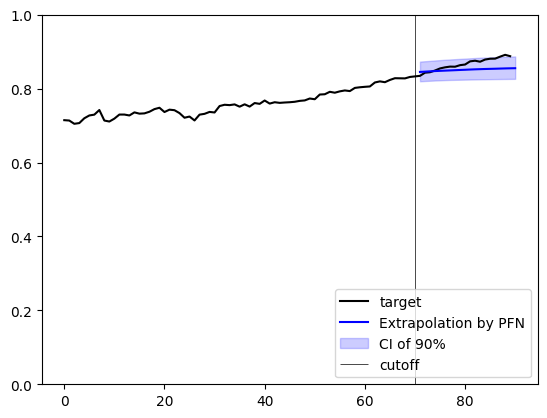

0.016704596214402002 85.0 1.1408477


In [15]:
random_idx = random.randint(0, test_data_UD.shape[0] - 1)
curve = test_data_UD[random_idx]  # (1, 137)
curve = curve[~np.isnan(curve)]

def evaluate(curve):
    y = torch.from_numpy(curve).float().unsqueeze(-1)
    x = torch.arange(1, y.shape[0] + 1).unsqueeze(-1).float()  
    
    # construct 
    num_last_anchor = 20
    cutoff = len(curve) - num_last_anchor
    
    x_train = x[:cutoff]
    y_train = y[:cutoff]
    x_test = x[cutoff:]
    qs = [0.05, 0.5, 0.95]
    
    normalizer = lcpfn.utils.identity_normalizer()
    
    y_train_norm = normalizer[0](y_train)
    
    # forward
    single_eval_pos = x_train.shape[0]
    x = torch.cat([x_train, x_test], dim=0).unsqueeze(1)
    y = y_train.unsqueeze(1)
    
    logits = model((x, y), single_eval_pos=single_eval_pos)
    
    predictions = normalizer[1](
        torch.cat([model.criterion.icdf(logits, q) for q in qs], dim=1)
    )
    
    x_test_np = x[cutoff:].detach().cpu().numpy().flatten()
    pred_mean = predictions[:, 1].detach().cpu().numpy()
    pred_lower = predictions[:, 0].detach().cpu().numpy()
    pred_upper = predictions[:, 2].detach().cpu().numpy()
    
    # pred_mean = pred_mean - pred_mean[0] + curve[cutoff]
    # pred_lower = pred_lower - pred_lower[0] + curve[cutoff]
    # pred_upper = pred_upper - pred_upper[0] + curve[cutoff]

    # plot
    plt.plot(curve, "black", label="target")
    plt.plot(x_test_np, pred_mean, "blue", label="Extrapolation by PFN")
    plt.fill_between(x_test_np, pred_lower, pred_upper, color="blue", alpha=0.2, label="CI of 90%")
    plt.vlines(cutoff, 0, 1, linewidth=0.5, color="k", label="cutoff")
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    plt.show()
    grountruth = curve[cutoff:]
    if len(grountruth) == 0:
        print(1)
    if len(pred_mean) == 0:
        print(2)
    #mse = np.sqrt(mean_squared_error(grountruth, pred_mean))
    mse =  np.mean(np.abs(grountruth - pred_mean))
    within_ci = (grountruth >= pred_lower) & (grountruth <= pred_upper)
    coverage = within_ci.mean() * 100

    ci_width = pred_upper - pred_lower
    area = ci_width.sum()


    return mse, coverage, pred_mean, grountruth, area
# 
mse, cov, _, _, area = evaluate(curve)
print(mse, cov, area)

    ### design your own metrics to evaluate

RMSE: 0.055560 +/- 0.069612
Coverage: 44.10 +/- 35.51


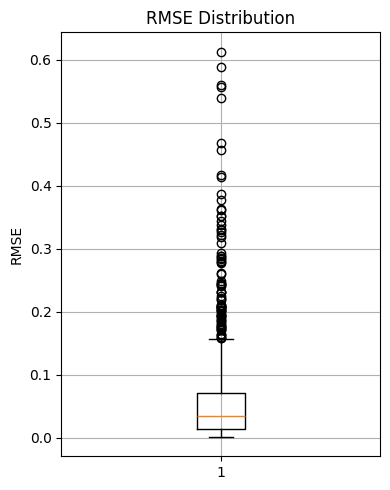

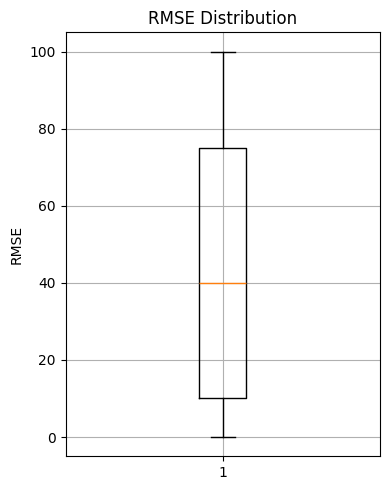

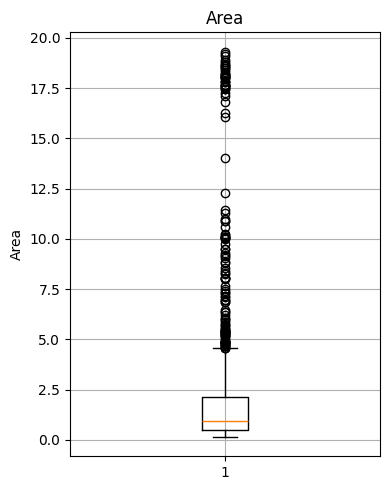

In [11]:
resultsRMSE = []
resultsCoverage = []
resulstsArea = []
for curve in UD_A:
    curve = curve[~np.isnan(curve)]
    if len(curve) == 0:
        continue
    mse, coverage,_,_, area = evaluate(curve)
    resultsRMSE.append(mse)
    resultsCoverage.append(coverage)
    resulstsArea.append(area)


boxplot_data = resultsRMSE
# resultsRMSE = np.array(resultsRMSE) + 1e-8
# log_data = np.log(resultsRMSE)
# transformed_data, lambda_ = stats.boxcox(resultsRMSE)


# mean_log = np.mean(resultsRMSE)
# se_log = np.std(resultsRMSE, ddof=1)

# print(f"log(RMSE): {mean_log:.6f} ± {se_log:.6f}")
# 
# plt.errorbar(0, mean_log, yerr=se_log, fmt='o', capsize=5)
# plt.xlim(-1, 1)
# plt.xticks([0], ['Sample'])
# plt.ylabel('log(RMSE)')
# plt.title('Log-Mean ± Standard Error')
# plt.grid(True)
# plt.show()



# 
print(f"RMSE: {np.mean(resultsRMSE):.6f} +/- {np.std(resultsRMSE):.6f}")
print(f"Coverage: {np.mean(resultsCoverage):.2f} +/- {np.std(resultsCoverage):.2f}")
plt.figure(figsize=(4, 5))
plt.boxplot(boxplot_data, vert=True)
plt.title("RMSE Distribution")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 5))
plt.boxplot(resultsCoverage, vert=True)
plt.title("RMSE Distribution")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 5))
plt.boxplot(resulstsArea, vert=True)
plt.title("Area")
plt.ylabel("Area")
plt.grid(True)
plt.tight_layout()
plt.show()

# rmse_array = np.array(resultsRMSE)
# 
# # Compute IQR
# Q1 = np.percentile(rmse_array, 25)
# Q3 = np.percentile(rmse_array, 75)
# IQR = Q3 - Q1
# 
# # Define bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR
# 
# # Filter non-outliers
# rmse_non_outliers = rmse_array[(rmse_array >= lower_bound) & (rmse_array <= upper_bound)]
# print(f"Non-outlier RMSE: {np.mean(rmse_non_outliers)}, {np.std(rmse_non_outliers)}")
# 
# plt.figure(figsize=(4, 5))
# plt.boxplot(rmse_non_outliers, vert=True)
# plt.title("RMSE Distribution")
# plt.ylabel("RMSE")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [161]:
Seeds = [5, 20, 42]
for seed in Seeds:
    model = torch.load(f'Mixed_Training_{Learner_A}_{Learner_B}_{train_split}_{seed}.pth', weights_only=False)
    model.eval()
    
    resultsRMSE = []
    resultsCoverage = []
    for curve in test_data_UD:
        curve = curve[~np.isnan(curve)]
        if len(curve) == 0:
            continue
        mse, coverage,_,_ = evaluate(curve)
        resultsRMSE.append(mse)
        resultsCoverage.append(coverage)

    print(f"RMSE: {np.mean(resultsRMSE):.6f} +/- {np.std(resultsRMSE):.6f}")
    print(f"Coverage: {np.mean(resultsCoverage):.2f} +/- {np.std(resultsCoverage):.2f}")


RMSE: 0.053444 +/- 0.056674
Coverage: 53.68 +/- 32.92
RMSE: 0.084591 +/- 0.114996
Coverage: 50.62 +/- 38.12
RMSE: 0.066544 +/- 0.108424
Coverage: 55.98 +/- 34.92


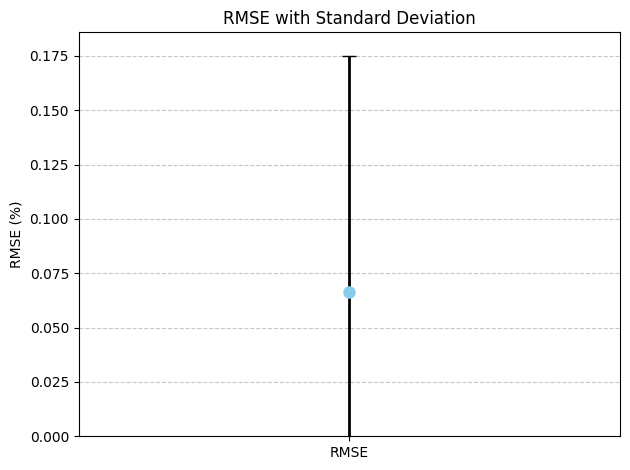

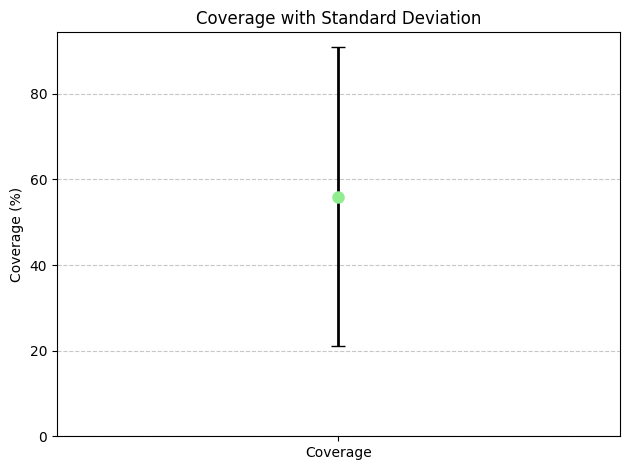

In [155]:
def plot_metric_with_error(name, values, color='skyblue', ylabel='Value', units=''):
    """
    Plot a single metric as a point with an error bar.

    Parameters:
    - name: str, label for the x-axis (e.g., 'Coverage')
    - values: array-like, list or array of values
    - color: str, color of the point (default 'skyblue')
    - ylabel: str, label for the y-axis
    - units: str, optional, unit label to include in y-axis label
    """
    mean = np.mean(values)
    std = np.std(values)

    plt.figure()
    plt.errorbar(
        x=[0], y=[mean], yerr=[std],
        fmt='o', capsize=5, color=color, ecolor='black',
        elinewidth=2, markersize=8
    )
    plt.xticks([0], [name])
    plt.ylabel(f'{ylabel} {units}')
    plt.title(f'{name} with Standard Deviation')
    plt.ylim(bottom=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_metric_with_error('RMSE', resultsRMSE, color='skyblue', ylabel='RMSE', units='(%)')
plot_metric_with_error('Coverage', resultsCoverage, color='lightgreen', ylabel='Coverage', units='(%)')


In [8]:
import numpy as np
test_splits = np.linspace(0.0, 1.0, num=21)
print(test_splits)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [3]:
t =  [[1,2,3], [4,5,6]]
t = np.array(t)
print(t.flatten())

[1 2 3 4 5 6]


In [25]:
a = [[1, 2, 3], [4, 5, 6]]
print(np.mean(a,axis= 0))

[2.5 3.5 4.5]
